In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image
import torchvision
from torchvision import transforms, models, datasets
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torch.nn.functional as F

import colorama
from colorama import Fore, Style

from torchsummary import summary

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'DEVICE is : {DEVICE}')

DEVICE is : cuda


In [2]:
Root_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = Root_dir + "/train"
valid_dir = Root_dir + "/valid"
test_dir = "/kaggle/input/new-plant-diseases-dataset/test"
Diseases_classes = os.listdir(train_dir)

In [3]:
cnt = 0
plant_names = []
tot_images = 0

for i in Diseases_classes:
    cnt += 1
    plant_names.append(i)
    
    image_path = os.listdir(train_dir + "/" + i)
    print(Fore.GREEN)
    print("The Number of Images in " +i+ ":", len(image_path), end= " ")
    tot_images += len(image_path)

    
    
print("\n\nTotal Number of Images in Directory: ", tot_images)


The Number of Images in Tomato___Late_blight: 1851 
The Number of Images in Tomato___healthy: 1926 
The Number of Images in Grape___healthy: 1692 
The Number of Images in Orange___Haunglongbing_(Citrus_greening): 2010 
The Number of Images in Soybean___healthy: 2022 
The Number of Images in Squash___Powdery_mildew: 1736 
The Number of Images in Potato___healthy: 1824 
The Number of Images in Corn_(maize)___Northern_Leaf_Blight: 1908 
The Number of Images in Tomato___Early_blight: 1920 
The Number of Images in Tomato___Septoria_leaf_spot: 1745 
The Number of Images in Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 1642 
The Number of Images in Strawberry___Leaf_scorch: 1774 
The Number of Images in Peach___healthy: 1728 
The Number of Images in Apple___Apple_scab: 2016 
The Number of Images in Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1961 
The Number of Images in Tomato___Bacterial_spot: 1702 
The Number of Images in Apple___Black_rot: 1987 
The Number of Images in Blueberry___heal

In [ ]:
plant_names = []
Len = []
for i in Diseases_classes:
    plant_names.append(i)
    imgs_path = os.listdir(train_dir + "/" + i)
    Len.append(len(imgs_path))

Len.sort(reverse=True)

sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,20),dpi=200)
ax = sns.barplot(x= Len, y= plant_names, palette="Greens")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # Normalize the data to [-1, 1]
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # Normalize the data to [-1, 1]
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # Normalize the data to [-1, 1]
])

In [6]:
train = datasets.ImageFolder(root=train_dir, transform=train_transform)
valid = datasets.ImageFolder(root=valid_dir, transform=val_transform)

In [7]:
# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [8]:
# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dataloader:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

In [9]:
batch_size = 32
# DataLoaders for training and validation
train_dataloader = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dataloader = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [10]:
# Moving data into GPU, WrappedDataLoader
train_dataloader = DeviceDataLoader(train_dataloader, DEVICE)
valid_dataloader = DeviceDataLoader(valid_dataloader, DEVICE)

In [11]:
from torchvision import models
import torch.nn as nn

def get_resnext_model(num_classes, feature_extract=True):
    model = models.resnext50_32x4d(pretrained=True)

    # Freeze layers if doing feature extraction
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False

    # Replace the final fully connected layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    return model


In [13]:
from tqdm import tqdm

def train_model(model, train_loader, valid_loader, optimizer, criterion, num_epochs=10, model_path="best_model.pth"):
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc='Training', leave=False)
        for images, labels in loop:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            
            loss = criterion(outputs, labels)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
            loop.set_postfix(loss=loss.item(), acc=100*correct/total)

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        print(f'Training Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%')

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = 100 * val_correct / val_total
        val_loss = val_loss / len(valid_loader)
        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%')

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), model_path)
            print(Fore.YELLOW + f"✅ Best model saved with accuracy: {best_acc:.2f}%" + Style.RESET_ALL)


In [15]:
num_classes = len(Diseases_classes)
model_resnext_feat = get_resnext_model(num_classes, feature_extract=True)
model_resnext_feat = model_resnext_feat.to(DEVICE)

# Only parameters of final layer
optimizer_feat = torch.optim.Adam(model_resnext_feat.fc.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_model(model_resnext_feat, train_dataloader, valid_dataloader,
            optimizer_feat, criterion, num_epochs=10,
            model_path="resnext_feature_extractor.pth")


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 149MB/s] 



Epoch 1/10


Training Loss: 0.4205, Accuracy: 89.19%


Validation Loss: 0.1894, Accuracy: 94.01%
✅ Best model saved with accuracy: 94.01%

Epoch 2/10


Training Loss: 0.1825, Accuracy: 94.17%


Validation Loss: 0.1555, Accuracy: 95.10%
✅ Best model saved with accuracy: 95.10%

Epoch 3/10


Training Loss: 0.1558, Accuracy: 94.91%


Validation Loss: 0.1488, Accuracy: 95.27%
✅ Best model saved with accuracy: 95.27%

Epoch 4/10


Training Loss: 0.1337, Accuracy: 95.54%


Validation Loss: 0.1351, Accuracy: 95.67%
✅ Best model saved with accuracy: 95.67%

Epoch 5/10


Training Loss: 0.1272, Accuracy: 95.72%


Validation Loss: 0.1300, Accuracy: 95.81%
✅ Best model saved with accuracy: 95.81%

Epoch 6/10


Training Loss: 0.1153, Accuracy: 96.13%


Validation Loss: 0.1155, Accuracy: 96.43%
✅ Best model saved with accuracy: 96.43%

Epoch 7/10


Training Loss: 0.1111, Accuracy: 96.24%


Validation Loss: 0.1128, Accuracy: 96.26%

Epoch 8/10


Training Loss: 0.1038, Accuracy: 96.51%


Validation Loss: 0.1110, Accuracy: 96.46%
✅ Best model saved with accuracy: 96.46%

Epoch 9/10


Training Loss: 0.0983, Accuracy: 96.62%


Validation Loss: 0.1101, Accuracy: 96.55%
✅ Best model saved with accuracy: 96.55%

Epoch 10/10


Training Loss: 0.0958, Accuracy: 96.73%


Validation Loss: 0.1060, Accuracy: 96.66%
✅ Best model saved with accuracy: 96.66%


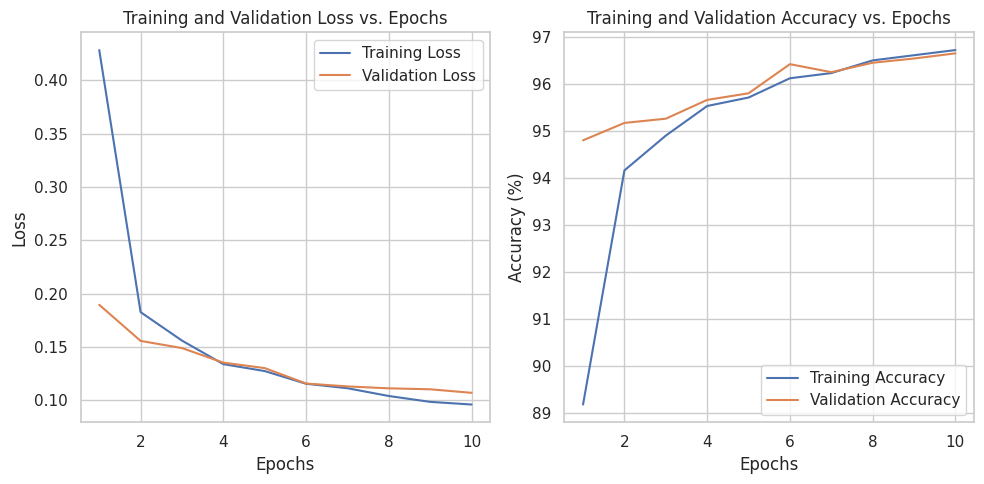

In [16]:
import matplotlib.pyplot as plt

# Pre-defined lists of values for this new model (10 epochs)
epochs = list(range(1, 11))
training_losses = [0.4285, 0.1825, 0.1558, 0.1337, 0.1272, 0.1153, 0.1111, 0.1038, 0.0983, 0.0958]
validation_losses = [0.1894, 0.1555, 0.1488, 0.1351, 0.1300, 0.1155, 0.1128, 0.1110, 0.1101, 0.1068]
training_accuracies = [89.19, 94.17, 94.91, 95.54, 95.72, 96.13, 96.24, 96.51, 96.62, 96.73]
validation_accuracies = [94.81, 95.18, 95.27, 95.67, 95.81, 96.43, 96.26, 96.46, 96.55, 96.66]

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.legend()
plt.grid(True)

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracies, label='Training Accuracy')
plt.plot(epochs, validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy vs. Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_and_plot_confusion_matrix(model, dataloader, class_names, model_path=None):
    model.eval()
    model.to(DEVICE)

    if model_path:
        model.load_state_dict(torch.load(model_path))
        print(f"✅ Loaded weights from {model_path}")

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"\n✅ Validation Accuracy: {acc*100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


✅ Loaded weights from resnext_feature_extractor.pth

✅ Validation Accuracy: 96.66%


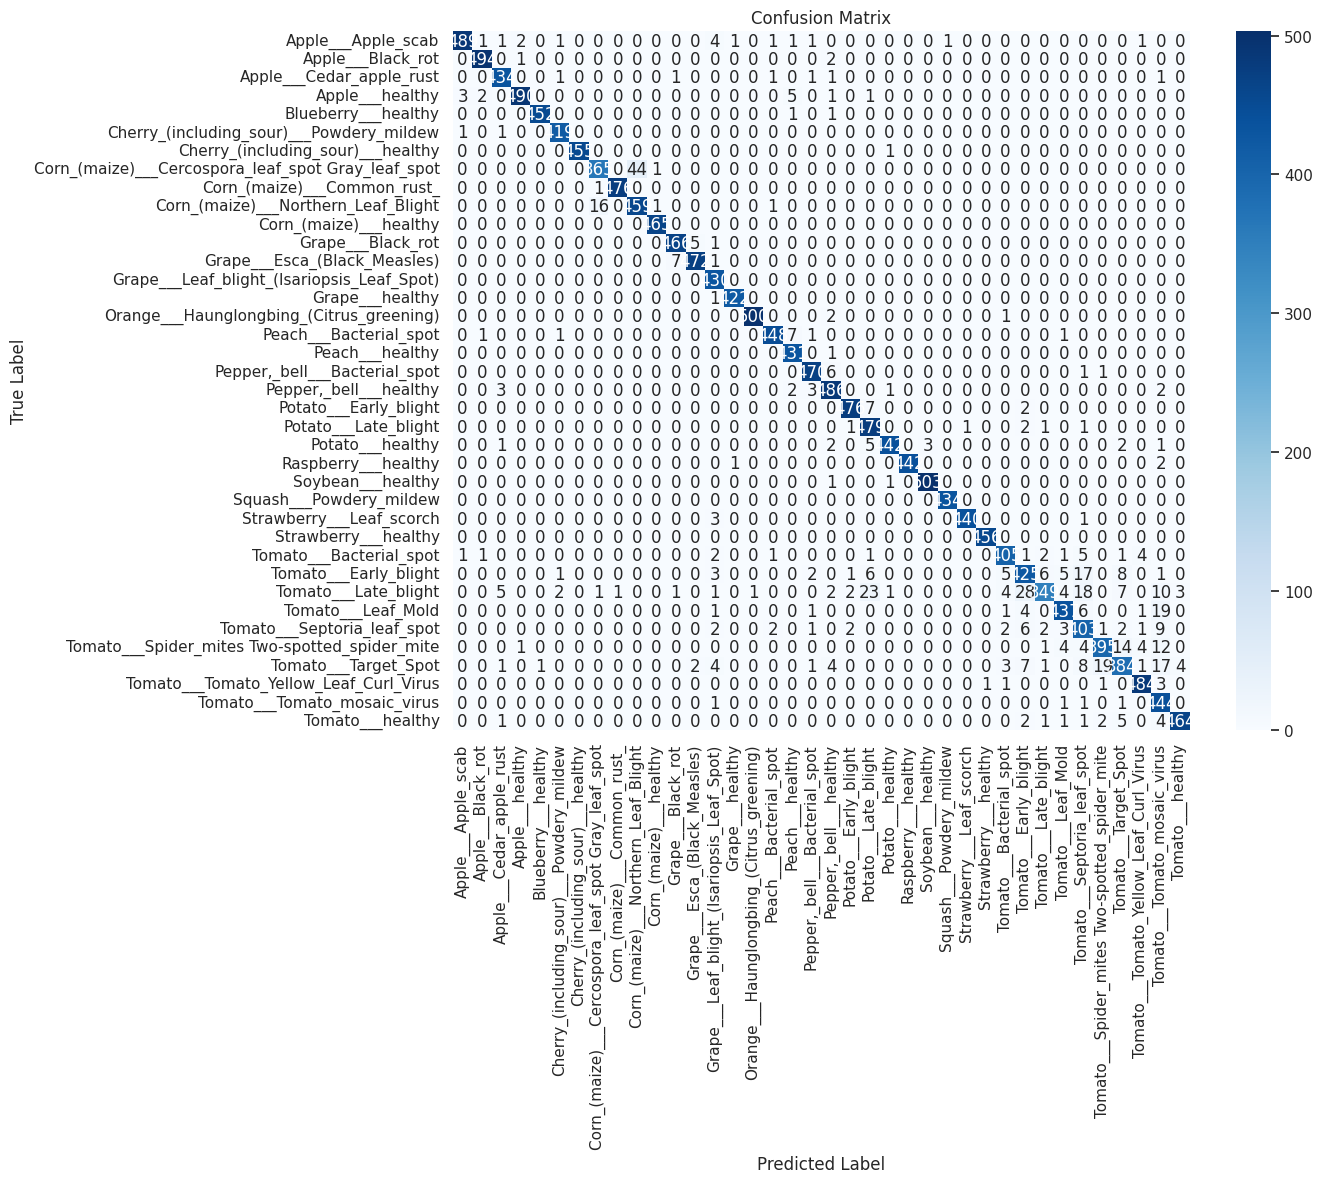

In [20]:
# Assume your label encoder or dataset has class names in this order:
idx_to_class = {v: k for k, v in train.class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

# Load model again or use already-loaded model
evaluate_and_plot_confusion_matrix(model_resnext_feat, valid_dataloader, class_names, model_path="resnext_feature_extractor.pth")


COMPLETE FINE TUNING UNFREEZING THE CONVOLUTION LAYER

In [22]:
model_resnext_finetune = get_resnext_model(num_classes, feature_extract=False)
model_resnext_finetune = model_resnext_finetune.to(DEVICE)

# All parameters
optimizer_finetune = torch.optim.Adam(model_resnext_finetune.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

train_model(model_resnext_finetune, train_dataloader, valid_dataloader,
            optimizer_finetune, criterion, num_epochs=4,
            model_path="resnext_finetuned.pth")



Epoch 1/4


Training Loss: 0.1219, Accuracy: 96.96%


Validation Loss: 0.0175, Accuracy: 99.43%
✅ Best model saved with accuracy: 99.43%

Epoch 2/4


Training Loss: 0.0319, Accuracy: 99.05%


Validation Loss: 0.0269, Accuracy: 99.29%

Epoch 3/4


Training Loss: 0.0230, Accuracy: 99.33%


Validation Loss: 0.0111, Accuracy: 99.66%
✅ Best model saved with accuracy: 99.66%

Epoch 4/4


Training Loss: 0.0196, Accuracy: 99.44%


Validation Loss: 0.0199, Accuracy: 99.44%


In [23]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_and_plot_confusion_matrix(model, dataloader, class_names, model_path=None):
    model.eval()
    model.to(DEVICE)

    if model_path:
        model.load_state_dict(torch.load(model_path))
        print(f"✅ Loaded weights from {model_path}")

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"\n✅ Validation Accuracy: {acc*100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


✅ Loaded weights from resnext_finetuned.pth

✅ Validation Accuracy: 99.66%


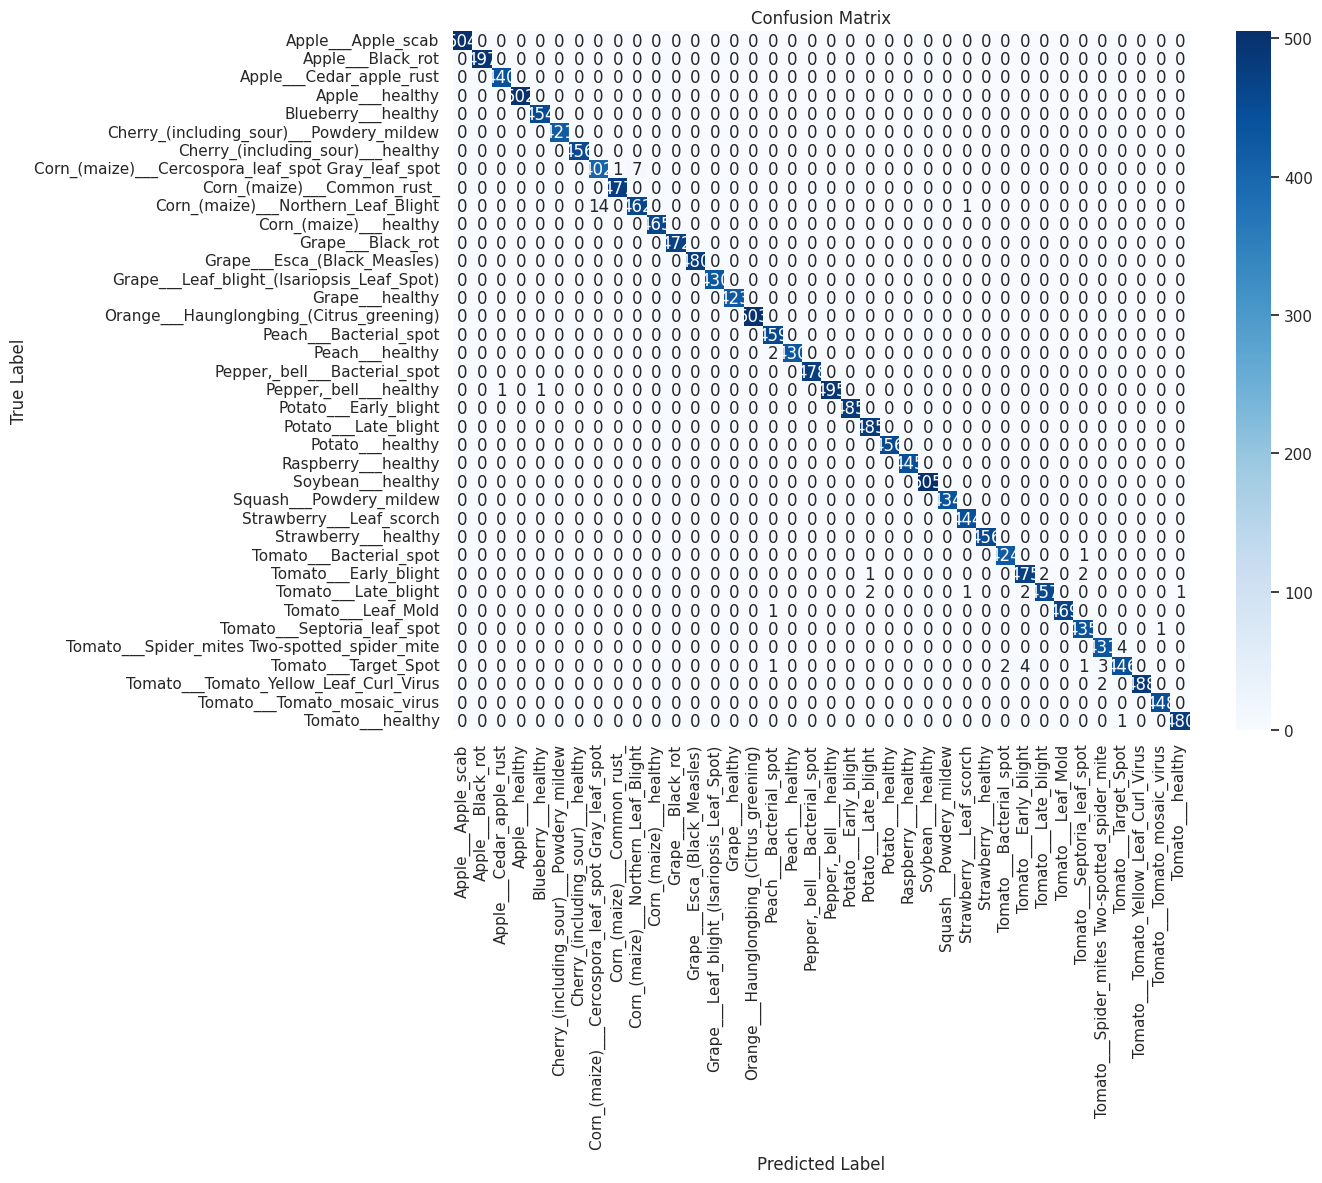

In [24]:
# Assume your label encoder or dataset has class names in this order:


# Load model again or use already-loaded model
evaluate_and_plot_confusion_matrix(model_resnext_finetune, valid_dataloader, class_names, model_path="resnext_finetuned.pth")

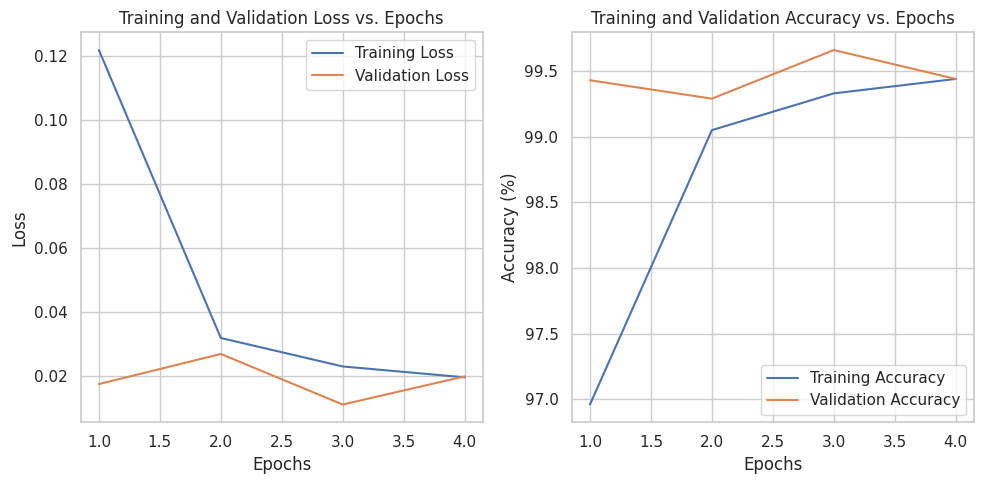

In [25]:
import matplotlib.pyplot as plt

# Pre-defined lists of values for this model (4 epochs)
epochs = list(range(1, 5))
training_losses = [0.1219, 0.0319, 0.0230, 0.0196]
validation_losses = [0.0175, 0.0269, 0.0111, 0.0199]
training_accuracies = [96.96, 99.05, 99.33, 99.44]
validation_accuracies = [99.43, 99.29, 99.66, 99.44]

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.legend()
plt.grid(True)

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracies, label='Training Accuracy')
plt.plot(epochs, validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy vs. Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


###  **Dataset Overview**

* **Classes:** 38 plant disease classes across various crops (e.g., Tomato, Apple, Grape, Corn, etc.), including both healthy and diseased categories.
* **Distribution:** Slightly imbalanced but reasonably uniform, with class sizes ranging from \~1640 to \~2022 images.
* **Challenges:**

  * Fine-grained inter-class variations (e.g., different tomato diseases look visually similar).
  * Intra-class variability due to lighting, leaf orientation, and background noise.
  * Subtle visual features that require high-resolution understanding.

---

###  **Pipeline Overview**

* **Architectures:**

  * **Inception v3** and **ResNeXt-50\_32x4d** (both pretrained on ImageNet).
* **Data Preprocessing:**

  * Resize to 299×299 for Inception, 224×224 for ResNeXt.
  * Normalization using ImageNet mean/std.
  * Augmentations: Random flips, rotations, and color jitter.
* **Training Approach:**

  * Two strategies:

    1. **Feature Extraction** (freeze all except classifier).
    2. **Fine-Tuning** (unfreeze backbone + classifier, retrain end-to-end).
  * Optimizer: Adam; Loss: CrossEntropyLoss.

---

###  **Experiments**

| Model             | Strategy           | Validation Accuracy |
| ----------------- | ------------------ | ------------------- |
| Inception v3      | Feature Extraction | **95.00%**          |
| Inception v3      | Fine-Tuned         | **99.62%**          |
| ResNeXt-50\_32x4d | Feature Extraction | **96.66%**          |
| ResNeXt-50\_32x4d | Fine-Tuned         | **99.66%**          |

* **Conclusion:** Fine-tuning significantly improves performance. ResNeXt slightly outperforms Inception in both settings.

---

###  **Visualizations**

* **Training Curves:** (Accuracy & Loss vs Epochs) show fast convergence for both models.
* **Confusion Matrices:**

  * Feature-extracted models misclassify visually similar classes more often.
  * Fine-tuned models have minimal confusion.
* **Grad-CAMs (optional):** Can highlight the disease-affected regions — useful for interpretability and model trust.

---

###  **Discussion**

* **What worked well:**

  * Transfer learning with fine-tuning boosted accuracy drastically.
  * Both architectures handled subtle visual patterns well after unfreezing.
* **What didn’t:**

  * Feature extraction alone underperformed for classes with small inter-class differences.
  * Some confusion still exists between closely related diseases.
* **Future Improvements:**

  * Use class rebalancing (e.g., focal loss) to address remaining bias.
  * Add ensemble of top-performing models.
  * Use higher-resolution images and apply Grad-CAMs for interpretability and trust.

